[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fonnesbeck/Bios8366/blob/master/notebooks/Section7_3-Bayesian-Neural-Networks.ipynb)

# Bayesian Neural Networks in PyMC

Bayesian deep learning combines deep neural networks with probabilistic methods to provide information about the **uncertainty** associated with its predictions. Not only is accounting for prediction uncertainty important for real-world applications, it is also be useful in training. For example, we could train the model specifically on samples it is most uncertain about.

We can also quantify the uncertainty in our estimates of network weights, which could inform us about the **stability** of the learned representations of the network.

In classical neural networks, weights are often L2-regularized to avoid overfitting, which corresponds exactly to Gaussian priors over the weight coefficients. We could, however, imagine all kinds of other priors, like spike-and-slab to enforce sparsity (this would be more like using the L1-norm).

If we wanted to train a network on a new object recognition data set, we could bootstrap the learning by placing informed priors centered around weights retrieved from other pre-trained networks, like [GoogLeNet](https://arxiv.org/abs/1409.4842). 

Additionally, a very powerful approach in Probabilistic Programming is **hierarchical modeling**, which allows pooling of things that were learned on sub-groups to the overall population. Applied here, individual neural nets can be applied to sub-groups based on sharing information from the overall population. 

Let's generate another simulated classification dataset:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks')

import aesara
import aesara.tensor as tt
import pymc as pm
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

floatX = aesara.config.floatX

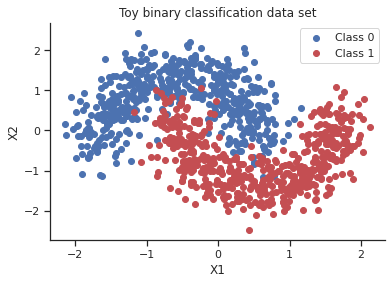

In [2]:
X, y = datasets.make_moons(noise=0.2, n_samples=1000)
X = scale(X)

fig, ax = plt.subplots()
ax.scatter(X[y==0, 0], X[y==0, 1], label='Class 0')
ax.scatter(X[y==1, 0], X[y==1, 1], color='r', label='Class 1')
sns.despine(); ax.legend()
ax.set(xlabel='X1', ylabel='X2', title='Toy binary classification data set');

The scaling performed above should result in faster training.

We first create training and test sets, and convert the training set to Theano tensors.

In [3]:
X = X.astype(floatX)
y = y.astype(floatX)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

ann_input = aesara.shared(X_train)
ann_output = aesara.shared(y_train)

Using standard normal deviates for initial values will facilitate convergence.

In [4]:
n_hidden = 5

init_1 = np.random.randn(X.shape[1], n_hidden).astype(floatX)
init_2 = np.random.randn(n_hidden, n_hidden).astype(floatX)
init_out = np.random.randn(n_hidden).astype(floatX)

Here we will use 2 hidden layers with 5 neurons each which is sufficient for such a simple problem.

In [7]:
with pm.Model() as neural_network:
    
    # Weights from input to hidden layer
    weights_in_1 = pm.Normal('w_in_1', 0, sigma=1, 
                             shape=(X.shape[1], n_hidden), 
                             initval=init_1)

    # Weights from 1st to 2nd layer
    weights_1_2 = pm.Normal('w_1_2', 0, sigma=1, 
                            shape=(n_hidden, n_hidden), 
                            initval=init_2)

    # Weights from hidden layer to output
    weights_2_out = pm.Normal('w_2_out', 0, sigma=1, 
                              shape=(n_hidden,), 
                              initval=init_out)

    # Build neural-network using tanh activation function
    act_1 = pm.math.tanh(pm.math.dot(ann_input, 
                                     weights_in_1))
    act_2 = pm.math.tanh(pm.math.dot(act_1, 
                                     weights_1_2))
    act_out = pm.math.sigmoid(pm.math.dot(act_2, 
                                          weights_2_out))

    # Binary classification -> Bernoulli likelihood
    out = pm.Bernoulli('out', 
                       act_out,
                       observed=ann_output,
                       total_size=y_train.shape[0] # IMPORTANT for minibatches
                      )

We could use Markov chain Monte Carlo sampling, which works pretty well in this case, but this will become very slow as we scale our model up to deeper architectures with more layers.

Instead, we will use the the ADVI variational inference algorithm. This is much faster and will scale better. Note, that this is a mean-field approximation so we ignore correlations in the posterior.

In [8]:
with neural_network:
    approx = pm.fit(n=3_0000)

/home/fonnesbeck/pymc/pymc/aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(


Finished [100%]: Average Loss = 161.38


As samples are more convenient to work with, we can very quickly draw samples from the variational approximation using the `sample` method.

In [ ]:
trace = approx.sample(draws=5000)

Plotting the objective function (ELBO) we can see that the optimization slowly improves the fit over time.

In [ ]:
plt.plot(-approx.hist, alpha=.3)
plt.legend()
plt.ylabel('ELBO')
plt.xlabel('iteration');

Now that we trained our model, lets predict on the hold-out set using a posterior predictive check (PPC). 

1. We can use [`sample_ppc()`](../api/inference.rst) to generate new data (in this case class predictions) from the posterior (sampled from the variational estimation).
2. To improve performance, is better to get the node directly and build theano graph using our approximation (`approx.sample_node`)

In [ ]:
# create symbolic input
x = tt.matrix('X')
# symbolic number of samples is supported, we build vectorized posterior on the fly
n = tt.iscalar('n')
# Do not forget test_values or set theano.config.compute_test_value = 'off'
x.tag.test_value = np.empty_like(X_train[:10])
n.tag.test_value = 100
_sample_proba = approx.sample_node(neural_network.out.distribution.p, 
                                   size=n,
                                   more_replacements={ann_input: x})
# It is time to compile the function
# No updates are needed for Approximation random generator 
# Efficient vectorized form of sampling is used
sample_proba = theano.function([x, n], _sample_proba)

In [ ]:
pred = sample_proba(X_test, 500).mean(0) > 0.5

In [ ]:
print('Accuracy = {:0.1f}%'.format((y_test == pred).mean() * 100))

In [ ]:
fig, ax = plt.subplots()
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
sns.despine()
ax.set(title='Predicted labels in testing set', xlabel='X1', ylabel='X2');

Let's look at what the classifier has learned.

For this, we evaluate the class probability predictions on a grid over the whole input space.

In [ ]:
grid = pm.floatX(np.mgrid[-3:3:100j,-3:3:100j])
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)

In [ ]:
ppc = sample_proba(grid_2d ,500)

The result is a probability surface corresponding to the model predictions.

In [ ]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], ppc.mean(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X1', ylabel='X2');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

However, unlike a classical neural network, we can also look at the standard deviation of the posterior predictive to get a sense for the uncertainty in our predictions. 

In [ ]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], ppc.std(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)');

---
## References

T. Wiecki and M. Kochurov. (2017) [Variational Inference: Bayesian Neural Networks](http://docs.pymc.io/notebooks/bayesian_neural_network_advi.html)

D. Rodriguez. (2013) [Basic [1 hidden layer] neural network on Python](http://danielfrg.com/blog/2013/07/03/basic-neural-network-python/).

D. Britz. (2015) [Implementing a Neural Network from Scratch](http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/)